# MTH 9855 Homework 7

## Junliang Zhou

Tel: (347) 276-1207

Email: gjimzhou@gmail.com

In [1]:
# Setup environment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Read raw data
allData=pd.read_csv("monthlyRets-clean.csv")
allData['DATE']=pd.to_datetime(allData['DATE'])

In [3]:
# Split raw data into cap and ret
capData=allData.iloc[:,1::2].copy()
retData=allData.iloc[:,2::2].copy()

capCols=capData.columns.values.tolist()
retCols=retData.columns.values.tolist()

# Clean data into [DATE,COUNTRY,USDCAP,TOTRET] 4 columns
countryDatas=[]
for capCol,retCol in zip(capCols,retCols):
    country=capCol.split('.')[1]
    countryData=pd.DataFrame(allData['DATE'])
    countryData['COUNTRY']=country
    countryData['USDCAP']=capData[capCol]
    countryData['TOTRET']=retData[retCol]
    countryData.loc[0,'TOTRET']=0
    countryDatas.append(countryData)
    
allDataCleaned=pd.concat(countryDatas)
allDataCleaned.head()

,DATE,COUNTRY,USDCAP,TOTRET
0,2000-02-29,aut,1.310790e+10,0.000000
1,2000-03-31,aut,1.224056e+10,0.045976
2,2000-04-30,aut,1.272333e+10,0.015384
3,2000-05-31,aut,1.230309e+10,0.031812
4,2000-06-30,aut,1.287187e+10,-0.013370


In [4]:
# Pivot cap and ret data
capDataPivot=allDataCleaned.pivot('DATE','COUNTRY')['USDCAP']
retDataPivot=allDataCleaned.pivot('DATE','COUNTRY')['TOTRET']
retDataPivot.head()

COUNTRY,aut,bel,che,deu,dnk,esp,fin,fra,gbr,irl,ita,nld,nor,prt,swe
DATE,,,,,,,,,,,,,,,
2000-02-29,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2000-03-31,0.045976,0.006910,0.081099,-0.001392,0.096038,-0.013373,0.035039,0.014743,0.059912,0.114680,-0.072412,0.014711,0.035176,-0.063432,-0.050949
2000-04-30,0.015384,0.014342,-0.001377,-0.043046,-0.023474,-0.039794,0.076664,0.016535,-0.031757,-0.036568,-0.018850,0.005666,0.040373,-0.056198,0.031323
2000-05-31,0.031812,0.040011,0.043772,-0.033461,0.046806,-0.065268,-0.111442,0.001998,0.009909,-0.084939,0.013116,0.004167,0.061513,-0.032379,-0.035812
2000-06-30,-0.013370,0.044092,0.004620,-0.034353,-0.026395,-0.009483,-0.044127,0.008744,-0.001564,-0.043050,0.024677,0.018869,0.053950,0.008374,-0.039925


In [5]:
# Mean correlation coefficients
retDataPivot.corr().mean().mean()

0.7007527411725873

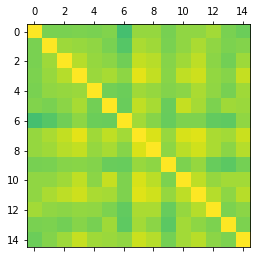

In [6]:
# Plot return correlation matrix
plt.matshow(retDataPivot.corr(), vmin=-1, vmax=1)
plt.show()

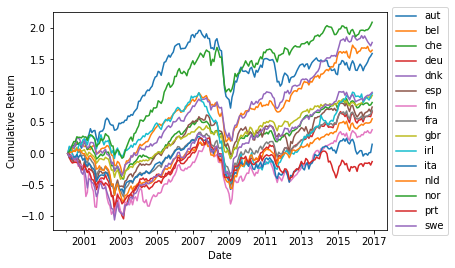

In [7]:
# Plot cumulative return for each country
allDataCleaned['CUMRET']=allDataCleaned.groupby('COUNTRY')['TOTRET'].cumsum()
allDataCleaned.set_index('DATE', inplace=True)
allDataCleaned.groupby('COUNTRY')['CUMRET'].plot()
plt.legend(loc=6, bbox_to_anchor=(1,0.5))
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()

In [8]:
def getPrior(retData,shrink,tau):
    S=np.diag(retData.var())
    rho_samp=np.array(retData.corr())
    rho=shrink*rho_samp+(1-shrink)*np.identity(retData.shape[1])
    Sigma=np.matmul(np.matmul(S,rho),S)
    Cinv=1/tau*np.linalg.inv(Sigma)
    
    return Sigma,Cinv

In [9]:
def getView(capData,N,q,omega):
    totalCap=sum(capData[[c for c in capData if c not in N]].iloc[time-1])
    P=np.array([1/len(N) if c in N else -capData[c].iloc[time-1]/totalCap for c in capData]).reshape(1,-1)
    heq=np.array(capData.iloc[time-1])/sum(capData.iloc[time-1])
    
    q=np.array(q).reshape(1,-1)
    Omegainv=np.array(1/omega).reshape(1,-1)
    
    return P,heq,q,Omegainv

In [10]:
# Define the Black-Litterman function
def computeBlackLitterman(retData,capData,N,shrink,tau,kappa,q,omega,time):
    Sigma,Cinv=getPrior(retData,shrink,tau)
    
    P,heq,q,Omegainv=getView(capData,N,q,omega)
    
    Pi=kappa*(1+tau)*np.dot(Sigma,heq).reshape(-1,1)
    Hinv=np.linalg.inv(np.dot(np.dot(P.transpose(),Omegainv),P)+Cinv)
    
    hopt=1/kappa*np.dot(np.matmul(np.linalg.inv(Hinv+Sigma),Hinv),np.dot(np.dot(P.transpose(),Omegainv),q)+np.dot(Cinv,Pi))
    hopt=hopt.flatten()
        
    req=np.dot(heq,retData.iloc[time])
    ropt=np.dot(hopt,retData.iloc[time])
    
    return heq,hopt,req,ropt

In [11]:
# Setup parameters
N=['nor','swe','dnk','fin']
T=retDataPivot.shape[0]
tau=0.01
kappa=1.0
shrink=0.5
q=0.01
omega=0.015**2
time=-1

In [12]:
# Compute BL coefficients
heq,hopt,req,ropt=computeBlackLitterman(retDataPivot,capDataPivot,N,shrink,tau,kappa,q,omega,time)
hopt

array([ 0.0023334 ,  0.01651113,  0.06309834,  0.07303791,  0.13624413,
        0.03056732,  0.12603297,  0.09003368,  0.12111268,  0.00460603,
        0.02065519,  0.03188954,  0.12584227,  0.00175969,  0.15627571])

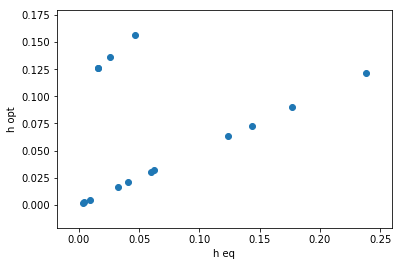

In [13]:
# Plot hopt against heq
plt.scatter(heq,hopt)
plt.xlabel('h eq')
plt.ylabel('h opt')
plt.show()

In [14]:
# Compute BL for a time period
rets=[computeBlackLitterman(retDataPivot,capDataPivot,N,shrink,tau,kappa,q,omega,t)[2:] for t in range(int(T/4),T)]
rets=pd.DataFrame(rets,columns=('Eq','Opt'))

date=pd.Series(allData.iloc[int(T/4):]['DATE'])
date.index=range(T-int(T/4))

rets['DATE']=date
rets.set_index('DATE', inplace=True)
rets.head()

,Eq,Opt
DATE,,
2004-04-30,0.018700,-0.010729
2004-05-31,-0.006669,-0.005651
2004-06-30,0.023032,0.036073
2004-07-31,-0.020467,-0.026298
2004-08-31,-0.005081,-0.000896


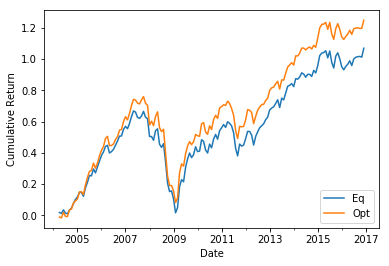

In [15]:
# Plot cumulative return for heq and hopt
rets.cumsum().plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.show()